In [2]:
using Pkg
Pkg.activate(".")

using Revise, PtyLab, TestImages, ImageShow, IndexFunArrays, FFTW, HDF5, Noise, FourierTools, CUDA
using EllipsisNotation
FFTW.set_num_threads(12)

  Activating environment at `~/PtyLab.jl/examples/Project.toml`


## Object

In [128]:
img_abs = ones(Float32, (1920, 1920))
FourierTools.center_set!(img_abs, Float32.(testimage("fabio_gray_512")))

img_phase = Float32.(testimage("resolution_test_1920"))
object = (img_abs .* cispi.(2 .* img_phase))[400:1500, 400:1500]

complex_show(object);

## Random Grid

In [129]:
grid_size = size(object)
tile_size = (600, 600)

grr = PtyLab.grid_regular_rand(grid_size, tile_size, (20, 20), 30);
@show grr.overlap
show_grid(grr, only_points=false);


grr.overlap = (0.9566666666666667, 0.9566666666666667)


## Probe

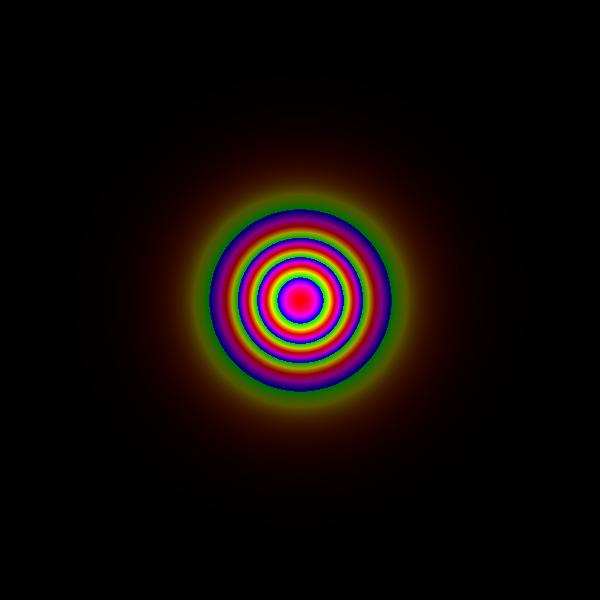

In [130]:
probe = IndexFunArrays.gaussian(Float32, tile_size, scale=0.00020) .* cis.(Float32(2π) .* 
     4 .* gaussian(Float32, tile_size, scale=0.0005));

complex_show(probe)

## Simulate and store as dataset

In [131]:
ptychogram = zeros(Float32, (tile_size..., length(grr.tiles)));
p = Params()
o2d, d2o = Fraunhofer(probe, fftshiftFlag=true);

for (i, t) in enumerate(grr.tiles)
    ptychogram[:, :, i] = abs2.(o2d(view(object, t.i₁:t.i₂,  t.j₁:t.j₂) .* probe))#, 200000)
end


lambda = 633f-9
z = 50f-3
dxd = 10f-6
Nd = size(ptychogram, 1)
dxo = lambda * z / (Nd * dxd)

fid_new = h5open("simulated_ptychography.hdf5", "w");
fid_new["Nd"] = Nd
fid_new["No"] = size(img_abs, 1)
fid_new["dxd"] = 10f-6

enc = PtyLab.encoder(grr, dxo, offset=(50, 50))
fid_new["encoder"] = enc .- maximum(enc) / 2
fid_new["wavelength"] = lambda
fid_new["entrancePupilDiameter"] = dxo * 50
fid_new["zo"] = z
fid_new["ptychogram"] = ptychogram
close(fid_new)
#@view_image ptychogram;

## Load dataset again

In [132]:
experimentalData = ExperimentalDataCPM("simulated_ptychography.hdf5");

reconstruction = ReconstructionCPM(experimentalData, cuda=false);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

engine = PtyLab.ePIE()
params2 = Params();

┌ Info: Reading HDF5.File: (read-only) simulated_ptychography.hdf5 was successful
└ @ PtyLab /home/fxw/PtyLab.jl/src/ExperimentalData.jl:55
┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/PtyLab.jl/src/utils_calc.jl:91


### On CPU

In [155]:
reconstruction = ReconstructionCPM(experimentalData, cuda=false);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);

#engines.
params2.fftshiftFlag = false
engine.betaProbe = 0.75f0
engine.betaObject = 0.75f0

params2.transposePtychogram = false
params2.comStabilizationSwitch = true
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);
engine.numIterations = 20

CUDA.@time p, o = PtyLab.reconstruct(engine, params2, reconstruction);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/PtyLab.jl/src/utils_calc.jl:91
┌ Warning: gimmel is currently estimated as `100 * eps(Float32)`
└ @ PtyLab /home/fxw/PtyLab.jl/src/Engines.jl:56
Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


135.119020 seconds (4.34 M CPU allocations: 1022.692 MiB, 0.10% gc time), 0.05% GPU memmgmt time


## On GPU

In [154]:
empty!(Out)
GC.gc()

reconstruction = ReconstructionCPM(experimentalData, cuda=true);
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);


#engines.
params2.fftshiftFlag = false
engine.betaProbe = 0.75f0
engine.betaObject = 0.75f0

params2.transposePtychogram = false
params2.comStabilizationSwitch = true
reconstruction = PtyLab.initializeObjectProbe!(reconstruction);
engine.numIterations = 20

CUDA.@time p, o = PtyLab.reconstruct(engine, params2, reconstruction);

┌ Warning: Currently No = 4 * Np, just as guess, should be improved
└ @ PtyLab /home/fxw/PtyLab.jl/src/utils_calc.jl:91
┌ Warning: gimmel is currently estimated as `100 * eps(Float32)`
└ @ PtyLab /home/fxw/PtyLab.jl/src/Engines.jl:56
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


 21.449817 seconds (7.68 M CPU allocations: 661.699 MiB, 0.59% gc time) (32.23 k GPU allocations: 763.708 MiB, 2.18% memmgmt time)


In [ ]:
22.651843 seconds (7.51 M CPU allocations: 642.309 MiB, 0.60% gc time) (48.23 k GPU allocations: 22.193 GiB, 27.24% memmgmt time)


In [ ]:
 34.954937 seconds (6.93 M CPU allocations: 609.755 MiB, 0.52% gc time) (88.22 k GPU allocations: 129.468 GiB, 62.49% memmgmt time)

In [156]:
complex_show(Array(reconstruction.probe[:, :, 1,1,1,1]));

In [157]:
complex_show(Array(o[:, :, 1,1,1,1]));